In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc
import numpy as np
import pandas as pd
from IMPJ import DataProcessor

data = pd.read_csv('..\\Fermi-LAT Data\\fl_numericalonly_nopositional_withclasses.csv', index_col=0)

test_size = 0.3

dp = DataProcessor()
X,Y = dp.choose_2_vars('CLASS1',data,1,2)
print(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,random_state=4) 

NN = MLPClassifier(activation='relu', alpha= 0.0001, hidden_layer_sizes=(30,20,10), learning_rate='constant', solver='sgd', random_state=1, max_iter=10000)
BNN = BaggingClassifier(estimator=NN,n_estimators=10,bootstrap=True)

# Define the pipeline
pipeline = Pipeline([
    ('logtransform',FunctionTransformer(func=dp.logtransform)),
    ('scaler', StandardScaler()),
    ('classifier', BNN)
])

# Fit the pipeline on the training data
pipeline.fit(x_train,y_train)

y_pred = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)

accuracy = accuracy_score(y_test, y_pred)*100
confusion = confusion_matrix(y_test, y_pred)
print('The Neural Network accuracy is ' + str(accuracy))
print('The Neural Network Confusion Matrix is:')
print(confusion)


check1
[0. 0. 0. ... 0. 0. 0.]
The Neural Network accuracy is 91.56626506024097
The Neural Network Confusion Matrix is:
[[253  14]
 [ 21 127]]


In [5]:
BNN_params = BNN.get_params
wandb.init(project='final-year-project', config=BNN_params)
wandb.config.update({"test_size" : test_size,
                    "train_len" : len(x_train),
                    "test_len" : len(x_test)})

plot_class_proportions(y_train, y_test, labels)
plot_learning_curve(BNN, x_train, y_train)
plot_roc(y_test, y_proba, labels)
plot_precision_recall(y_test, y_proba, labels)
#plot_feature_importances(model)

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()


(415, 57)


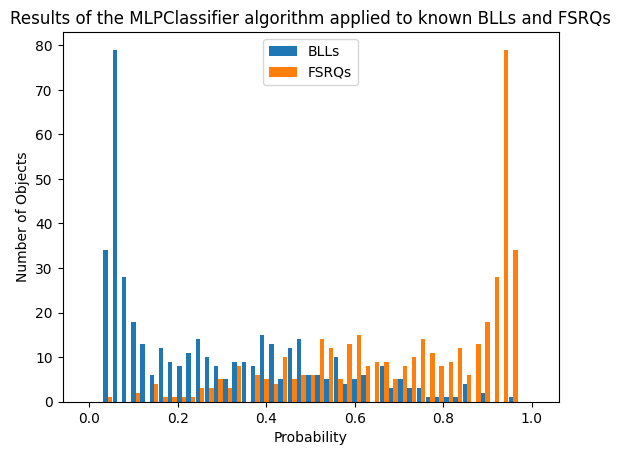

In [ ]:
import matplotlib.pyplot as plt
#print(y_proba)
probs = pd.DataFrame(y_proba,columns=('p_1','p_2'))
bin_probs_1 = pd.cut(probs['p_1'],np.linspace(0,1,50),include_lowest=True)
bin_probs_2 = pd.cut(probs['p_2'],np.linspace(0,1,50),include_lowest=True)

print(x_test.shape)

fig, ax = plt.subplots()
x_axis = np.linspace(0,1,len(bin_probs_1.value_counts()))

ax.bar(x_axis-0.005,bin_probs_1.value_counts(sort=False), width=0.01,label='BLLs')
ax.bar(x_axis+0.005,bin_probs_2.value_counts(sort=False),width=0.01,label='FSRQs')
ax.legend()
ax.set_xlabel('Probability')
ax.set_ylabel('Number of Objects')
ax.set_title('Results of the MLPClassifier algorithm applied to known BLLs and FSRQs')

plt.show()